In [34]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt, matplotlib

matplotlib.rcParams['figure.figsize']=[12, 6]
matplotlib.rcParams['font.size']=24

## Data Science part 2: Classification

In this lesson we will walk through a classification problem: in this case, binary, so only two categories. We will use a kind of generalized linear model called *logistic regression* to carry out the task. 

## Binomial (Binary) Logistic Regression
In this scenario, we have exactly two dichotomous target variables (e.g., speech vs music) that we are trying to predict from a bunch of other variables that we have collected and labeled (i.e., our extracted "features").

### Load and visualize data
For this task we will look at the Titanic Survival dataset. We will see whether any of the available features can predict whether a person survived the sinking of the titanic.

In [35]:
data = pd.read_csv('TitanicSurvival.csv')

In [36]:
data.head()

,Unnamed: 0,survived,sex,age,passengerClass
0,"Allen, Miss. Elisabeth Walton",yes,female,29.0000,1st
1,"Allison, Master. Hudson Trevor",yes,male,0.9167,1st
2,"Allison, Miss. Helen Loraine",no,female,2.0000,1st
3,"Allison, Mr. Hudson Joshua Crei",no,male,30.0000,1st
4,"Allison, Mrs. Hudson J C (Bessi",no,female,25.0000,1st


In [37]:
#Find any null values (this shouldn't affect your projects, but can happen when you have incomplete data)
data.isnull().sum()

Unnamed: 0          0
survived            0
sex                 0
age               263
passengerClass      0
dtype: int64

Age has a bunch of missing values, so we will just delete those rows of data since models don't do well with missing, zero-valued, or NaN values. (This shouldn't be a problem for you with your data for 2526 you are working on for finals, but useful to know.)

In [38]:
data.dropna(inplace=True)
data.isnull().sum()

Unnamed: 0        0
survived          0
sex               0
age               0
passengerClass    0
dtype: int64

In the Pandas library, a column of data is the equivalent of a numpy array. Pandas calls a 1-dimensional column of data a `Series` object.  When you want to tally all the possible values of a Series, a handy function is `value_counts()`.

In [39]:
data['survived'].value_counts() # Count the (survived) column by counts of 'no/yes'
# to change to proportions instead of counts, pass the "value_counts" argument: normalize = True

no     619
yes    427
Name: survived, dtype: int64

We can pass the output from `value_counts()` directly to Pandas built-in plots (which runs matplotlib in the background.) Note that you can always run `pandas.Series.to_numpy()` to convert Series objects back to numpy arrays. (You can also run `.to_numpy()` on DataFrame objects to create multidimensional array.)

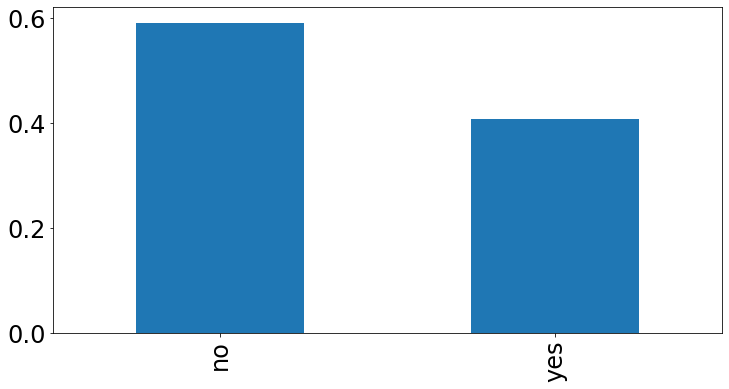

In [76]:
data['survived'].value_counts(normalize=True).plot.bar() # plot categorical data (survived) by counts
# to change to proportions instead of counts, pass the "value_counts" argument: normalize = True



When you have more than a single variable you'd like to count up (i.e., not just a Series object), you can use the `crosstab()` function. For example, let's look at counts of survival data according to gender:

In [41]:
pd.crosstab(data['sex'],data['survived'])

survived,no,yes
sex,,
female,96,292
male,523,135


Again, we can pass this table directly to bar plot, which will automatically create a multi-level bar plot with a legend:

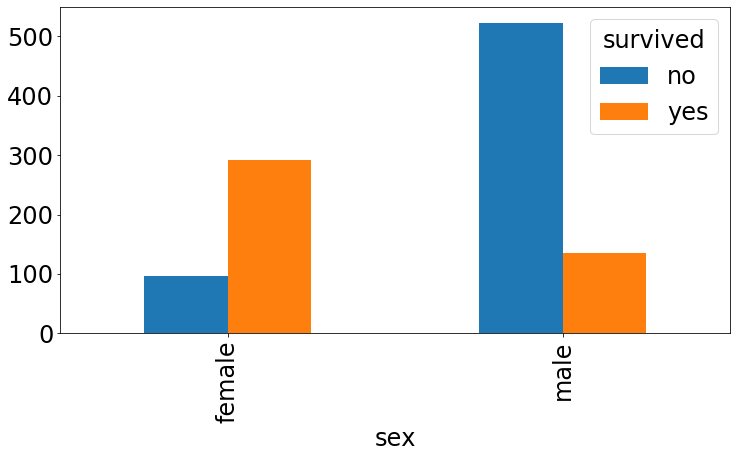

In [42]:
#investigate what features might be predictive of the yes/no classification
#the pandas crosstab function will count things based on some category/classification
pd.crosstab(data['sex'],data['survived']).plot.bar()

Looks like gender would be a good predictor of survival, because there is a strong difference. We can also examine passenger class:

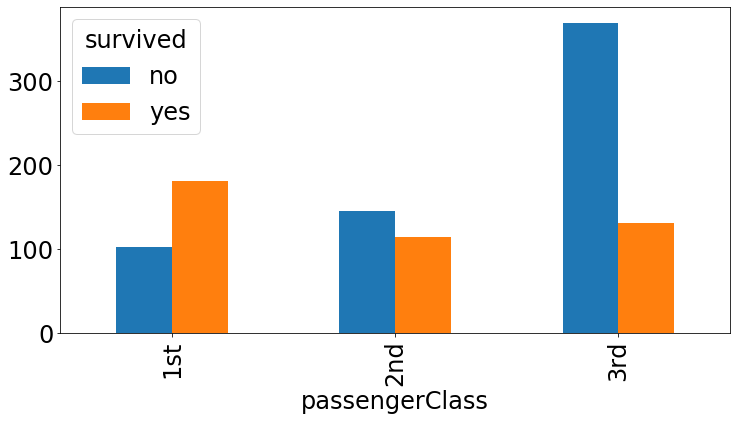

In [43]:
pd.crosstab(data['passengerClass'],data['survived']).plot.bar()

Ditto passenger class (visual differences).

Let's look at age, but now using a boxplot. A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile (Q1) or 25th percentile value, median, third quartile (Q3) or 75th percentile, and “maximum”). It can tell you about your outliers (dots extending past whiskers representing values that are more than 1.5x the interquartile range - which is within ~3.5% of the extreme ends of the distribution), and what their values are. It can also tell you if your data is symmetrical, how tightly your data is grouped, and if and how your data is skewed.

Text(0.5, 1.0, 'Survival by Age')

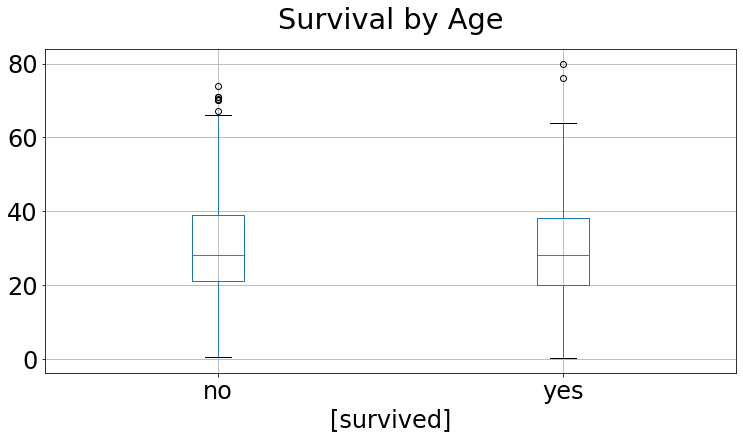

In [60]:
fig, ax = plt.subplots()
data.boxplot(by='survived', ax=ax)
#get rid of default title
fig.suptitle("")
#set your own title
ax.set_title('Survival by Age', pad=20)

looks like age probably isn't a great predictor because the distributions look very similar. Let's look at differences in age among passengers in each of the classes:

Text(0.5, 1.0, 'Survival by Passenger Class')

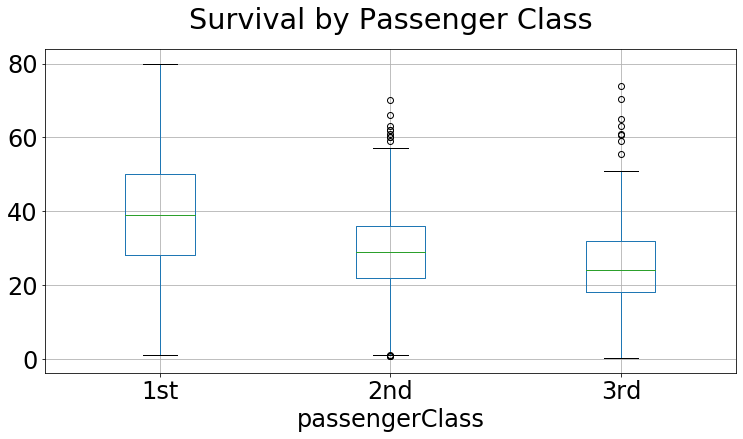

In [62]:
fig, ax = plt.subplots()
data.boxplot('age','passengerClass', ax=ax) #yaxis, xaxis
#possible slight correlation between age and passenger class (1st class tends to have slightly older people)
fig.suptitle("")
ax.set_title('Survival by Passenger Class', pad=20)

### NEXT YEAR: take out stuff on multicollinearity. See this:

https://online.stat.psu.edu/stat501/lesson/12/12.3 
    
"High multicollinearity among predictor variables does not prevent good, precise predictions of the response within the scope of the model.

Well, okay, it's not an effect, and it's not bad news either! It is good news! If the primary purpose of your regression analysis is to estimate a mean response

or to predict a new response y, you don't have to worry much about multicollinearity."



### Checking for Multicollinearity
Recall that our collective "bunch of variables" (or features) are called our **predictor variables**. But before throwing data about every potential predictor under the sun into your regression model, there is something to mention called "*multicollinearity.*" 

With regression--like many things--there comes a point where *more* is not necesssarily *better*. In fact, sometimes adding more factors to a regression model makes things harder to understand, and could even make things worse.

In regression, "multicollinearity" refers to *predictors that are strongly correlated with other predictors*.  In other words, it results when you have factors/features that are largely redundant. 

Features that are strongly correlated to each other increase something called the *standard error* - think of it like adding noise. This can have the unfortunate effect of making it seem like some feature isn't that important when it really is. 

**So, in other words: in regression models, strong correlations between features is bad!** 
How do I know if it's a problem? Examine correlations! 

Recall you can use `df.corr()` where `df` is the name of your pandas dataframe to examine the correlations between columns of features. You should only have numerical variables, but in this case we have some categoricals that have to be converted to numerical 'placeholders'. We call these "dummy variables".

A dummy variable (aka, an indicator variable) is a numeric variable that represents **categorical data**, such as gender, race, political affiliation, etc. (Note: You probably will not have any categorical data.) It is necessary to do this so that the model can understand the data properly.

In [63]:
gender = pd.get_dummies(data['sex'],drop_first=True)
gender.head() #notice now only one sex category (defaults to first in list) and all items are members or not

,male
0,0
1,1
2,0
3,1
4,0


In [64]:
#do the same for all categorical variables
pClass = pd.get_dummies(data['passengerClass'],drop_first=True)
survd = pd.get_dummies(data['survived'],drop_first=True)

we will drop the columns of data 'survived', 'sex', and 'passengerClass' and replace them with our new "dummies" columns. Since the indices provide a way of tracking each unique passenger (or ID), we can also drop the names column.

In [15]:
data.drop(['Unnamed: 0','sex', 'survived','passengerClass'],axis=1,inplace=True)
data_dmy = pd.concat([survd,data,gender,pClass],axis=1) #good practice to put the target variable in the first (or last) column

In [16]:
data_dmy.head()

,yes,age,male,2nd,3rd
0,1,29.0000,0,0,0
1,1,0.9167,1,0,0
2,0,2.0000,0,0,0
3,0,30.0000,1,0,0
4,0,25.0000,0,0,0


In [77]:
data_dmy.corr()

AttributeError: 'DataFrame' object has no attribute 't'

Sometimes it is helpful to *visualize* these correlations. `pcolor` is a handy plotting tool in matplotlib. You can change the default color mapping by calling other "color maps". 

You can check out the color maps output (and the code to generate them) for most color profiles [here](https://scipy-cookbook.readthedocs.io/items/Matplotlib_Show_colormaps.html). Note: In general, it has been shown that monochromatic graphs are easier for people to interpret.

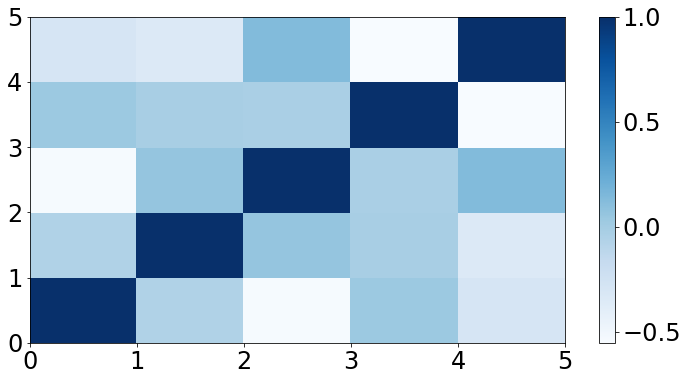

In [18]:
plt.pcolor(data_dmy.corr(), cmap='Blues') 
plt.colorbar()

No strong correlations here. Let's move on.

Recall we need to split up our dataset into data for training, and data for testing. We'll use the `sklearn` package to do this

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

You will use a simple Logistic regression model any time you have a dichotomous variable that you are trying to classify on (e.g., Speech/Music). When you have more than two categories, it's still logistic regression, but we call that **multinomial logistic regression** (let's come back to that.)

Let's split dataset by using function `train_test_split()`. You need to pass 3 parameters: features (predictors), target (categories), and test_set size. 

In [20]:
#if you don't know what I'm indexing here, go back and watch the pandas videos from Lesson 22.
#"categories" is my set of dependent variables; the thing I am trying to classify by
categories = data_dmy.iloc[:,1:]
predictors = data_dmy.iloc[:,0]

In [21]:
#divide up data into four groups two training and two testing of both dependent and independent variables.
#test size is typically anywhere from .5 to .2 depending on how much data you have. 
#For class purposes a training of about 2/3 of data and testing with the other 1/3 is appropriate.m 
pred_train, pred_test, cat_train, cat_test = train_test_split(categories, predictors, test_size = .3, random_state=25)

Below is where you actually pass the data to a specific model. 

In [66]:
model = LogisticRegression(solver='lbfgs') #for simple binary logistic regression we can use all default parameters
model.fit(pred_train, cat_train)
predictions = model.predict(pred_test)

In [67]:
model.coef_

array([[-0.02898469, -2.30018395, -1.14353657, -2.18113167]])

In [74]:
coeffs = pd.Series(model.coef_[0])
coeffs = dict(zip(data_dmy.columns[1:], model.coef_[0]))
coeffs

{'age': -0.02898468821883319,
 'male': -2.300183946915674,
 '2nd': -1.1435365724098776,
 '3rd': -2.181131669679591}

### Model Evaluation Using the Confusion Matrix

After we train a logistic regression model on the training data, we will evaluate the performance of the model on the test data. To evalute the output, we rely on something called a "Confusion Matrix". A Confusion Matrix is a table that is often used to describe the performance of the classification model on a set of test data for which the true values (i.e., ground truth) are already known. 

Here, TP stands for True Positive which are the cases in which we predicted yes and the actual value was true. TN stands for True Negative which are the cases in which we predicted no and the actual value was false.FP stands for False Positive which are the cases which we predicted yes and the actual value was False.FN stands for False Negative which are the cases which we predicted No and the actual value was true. (These are made up data from another dataset...just shown here for illustration.)

<img src="../images/confusionMatrix.png" align="center"/>

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cat_test, predictions)#parameters are y_truth (i.e.,Ground truth (correct) target values), y_pred (i.e., predicted values from model).
cm

array([[159,  28],
       [ 35,  92]])

In [26]:
#Convert to dataframe for easier reading:
pd.DataFrame(cm, columns=['Died','Survived'], index=['Predicts_died','Predicts_survived'])

,Died,Survived
Predicts_died,159,28
Predicts_survived,35,92


The actual values here will be different from each of you who runs this model, because the data forming the test set is being randomly selected.

My model is telling me that 159 and 92 are the True negatives and True positives, respectively. You should have estimates in a similar ballpark.

We can translate these values in each quadrant into the following categories:
    
#### True positives: 92
#### True negatives: 159
#### False positives: 35
#### False negatives: 28

#### What do we infer from the Confusion Matrix?

Confusion Matrix helps us determine how often the model prediction is correct or in other words, the **accuracy** of the model (what proportion of time is it correct). By the above table, It is given by:
( TP + TN ) / Total = 92 + 159 / 314 = .8

Accuracy is, in other words, intuitive: how often did the model 'get it right'?

In [27]:
(92+159)/314

0.7993630573248408

This means that the model is 80% correct. The Confusion Matrix is also used to measure the error rate (the leftover) which is given by:

( FP + FN ) / Total = 62 /314 = 0.197

There is 20% error in the model.

## Precision and Recall

A common way of evaluating a classification model is with *precision* and *recall* values. Precision and recall allows us to break down the 'accuracy' result into how many positives it is correctly identifying versus how many negatives. This is very important, for example, in medicine. You may invent a test to identify the presence of a disease. We want to separate:

a) What proportion of individuals "labeled positive" actually (truly) have the disease? (Precision)<br>
b) What proportion of actual positives (people with the disease) were correctly identified? (Recall, or 'sensitivity')


### Precision = 
   What percentage of the model's positives TRUE? = 
   
   True Positives / (True Positives + False Positives) = 
   
   92 / (92 + 35) = 72%

In [28]:
92 / (92 + 35)

0.7244094488188977

### Recall (a.k.a., sensitivity) = 
   What percentage of TRUE values does the model predict Positive? = 
   
   True Positives / (True Positives + False Negatives) = 
   
   49 / (49 + 178) = 77%

In [29]:
92 / (92 + 28)

0.7666666666666667

### F1-measure = 
   The *harmonic* mean ([see here](https://en.wikipedia.org/wiki/Harmonic_mean)) of precision and recall = 
   
   2 * (precision * recall) / (precision + recall) = 
   
   2 * ((.72 * .77) / (.72 + .77)) = 73%

In [30]:
   2 * ((.72 * .77) / (.72 + .77)) 

0.7441610738255033

### Need to know

I am teaching you about precision, recall, and F1 scores because they are important concepts in modeling and data science. However, for the purposes of this class, we are mainly interested in the accuracy score. That said, these other metrics can be very important for certain kinds of tasks, and are especially important when (a) data on the dependent measure are imbalanced (e.g., the majority of people died vs survived), or (b) you have a task where "one *kind* of right" (i.e., true positive vs true negative) is more important.

You can get all these values in one line by calling the `classification_report` function on your data:

In [31]:
from sklearn.metrics import classification_report, precision_recall_fscore_support
print(classification_report(cat_test, predictions))
#note we get precision and recall separately for positive and negative (e.g., 'What percentage of the model's negatives = False?' is also Precision)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       187
           1       0.77      0.72      0.74       127

    accuracy                           0.80       314
   macro avg       0.79      0.79      0.79       314
weighted avg       0.80      0.80      0.80       314



## Multinomial Logistic Regression

What's different if you have multiple possible categories (no longer binary) such as in a genre identification task?

Not much. You use the same `LogisticRegression` function above, however, you will change an important paramter:

`model = LogisticRegression(multi_class='multinomial', solver='lbfgs')`

You can leave your predictor categories in a single column and do not have to convert to dummy variables when creating the test/train data. 

Otherwise, everything is the same as shown here.